In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
import scipy
import statsmodels.api as sm

In [2]:
def getData(path):
    df = pd.read_csv(path, sep=',', header=0, index_col=0)
    return df

names = pickle.load(open('../../data/hosts/common_names.p', 'rb')) # Convert between common and scientific names
names['Chimp_pts'] = 'Pan_troglodytes_schweinfurthii'

bmr = getData('../../data/hosts/body_mass_rawdata.csv') # body mass values
hgd = getData('../../data/hosts/hostdistance_rawdata.csv') # host genetic distance
hgd_names = { i: i.split('|')[2] for i in list(hgd.columns.values)+list(hgd.index.values) } # fix taxa -> host names
hgd.rename(columns=hgd_names, index=hgd_names, inplace=True)
hgd.rename(index={'P._t._schweinfurthii': 'Pan_troglodytes_schweinfurthii'}, 
           columns = {'P._t._schweinfurthii': 'Pan_troglodytes_schweinfurthii'},
          inplace=True)

bf = getData('../../beast/main/discreteTraits/results/discreteTraits_2016-10-25_bf.csv') # Bayes factors

In [3]:
data = [] # Make tidy data
for from_host in bmr.index.values[1:]:
    for to_host in bmr.index.values[1:]:
        if from_host != to_host:
            transmission = 1 if bf.at[names[from_host], names[to_host]] >= 36.0 else 0 # Code transmission as binary variable
            bmr_val = bmr.at[from_host, 'mass'] / bmr.at[to_host, 'mass']
            hgd_val = hgd.at[from_host, to_host]
            data.append({ 'bmr': bmr_val, 'hgd': hgd_val, 'transmission': transmission, 'intercept': 1 } )
            
data = pd.DataFrame(data, columns=['transmission', 'intercept', 'bmr', 'hgd'])
data['log_bmr'] = data['bmr'].map(np.log10)

In [13]:
def make_quantiles(df, column):
    df['%s_quantiles'%column] = pd.qcut(df[column], 5, labels=range(5)) # Cut the data into quantiles (makes new categorical series column)
    x_means = [] # [x value means for each quantile]
    y_means = [] # [(y mean, (lower, upper 95% binary y CI)) for each quantile]
    y_ci = []
    
    for q in range(5):
        obs = df.loc[df['%s_quantiles'%column] == q] # observations in this quantile
        n_obs = len(obs) # number of observations in quantile
        n_transmissions = obs['transmission'].sum() # number of 1 values in quantile
        xmean = obs[column].mean() # mean predictor value in this quantile
        ymean = float(n_transmissions) / float(n_obs)
        ystddev = np.sqrt(float(n_obs)*ymean*(1-ymean))
        y95ci = 1.96*(ystddev/np.sqrt(n_obs))
        x_means.append(xmean)
        y_means.append(ymean)
        y_ci.append(y95ci)
    return {'x': x_means, 'y': y_means, 'y_ci': y_ci}
    
log_bmr_quantiles = make_quantiles(data, 'log_bmr')
hgd_quantiles = make_quantiles(data, 'hgd')
# bmr_quantiles = make_quantiles(data, 'bmr')

In [14]:
log_bmr_logit = sm.Logit(data['transmission'], data[['log_bmr', 'intercept']]).fit() # Logistic regression summary
hgd_logit = sm.Logit(data['transmission'], data[['hgd', 'intercept']]).fit()
print log_bmr_logit.summary()
print hgd_logit.summary()

Optimization terminated successfully.
         Current function value: 0.202398
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184935
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           transmission   No. Observations:                  506
Model:                          Logit   Df Residuals:                      504
Method:                           MLE   Df Model:                            1
Date:                Mon, 09 Jan 2017   Pseudo R-squ.:               0.0008416
Time:                        18:36:51   Log-Likelihood:                -102.41
converged:                       True   LL-Null:                       -102.50
                                        LLR p-value:                    0.6779
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
log_bm

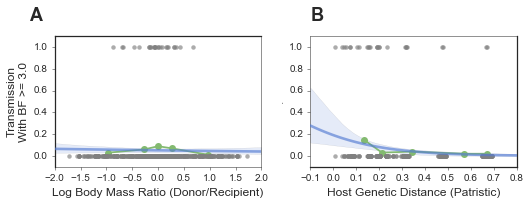

In [24]:
fig, (bmr_ax, hgd_ax) = plt.subplots(figsize=(7.5,3),nrows=1,ncols=2, facecolor='white')

bmr_ax.plot(log_bmr_quantiles['x'], log_bmr_quantiles['y'], 'o-', color='#83BA70')
hgd_ax.plot(hgd_quantiles['x'], hgd_quantiles['y'], 'o-', color='#83BA70')

sns.regplot(data['log_bmr'], data['transmission'], ax=bmr_ax, 
                        line_kws = {'color':'#547BD3', 'alpha': 0.65, 'zorder': 10}, 
                        scatter_kws={'color': 'gray', 'alpha': 0.65, 'zorder': 10}, logistic=True) # Standard logistic regression plots, includes raw values
sns.regplot(data['hgd'], data['transmission'], ax=hgd_ax,
                        line_kws = {'color':'#547BD3', 'alpha': 0.65, 'zorder': 10}, 
                        scatter_kws={'color': 'gray', 'alpha': 0.65, 'zorder': 10}, logistic=True)

hgd_ax.set_xlabel('Host Genetic Distance (Patristic)', size=12) # Label
bmr_ax.set_ylabel('Transmission\nWith BF >= 3.0', size=12)
bmr_ax.set_xlabel('Log Body Mass Ratio (Donor/Recipient)', size=12)
hgd_ax.set_ylabel(None, size=0)

bmr_ax.tick_params(axis='both', which='major', labelsize=10, width=0.5, length=3, top="off", right="off")
hgd_ax.tick_params(axis='both', which='major', labelsize=10, width=0.5, length=3, top="off", right="off")
hgd_ax.spines['left'].set_linewidth(0.5)
bmr_ax.spines['bottom'].set_linewidth(0.5)
hgd_ax.spines['left'].set_linewidth(0.5)
bmr_ax.spines['bottom'].set_linewidth(0.5)
hgd_ax.spines['top'].set_linewidth(0.5)
bmr_ax.spines['right'].set_linewidth(0.5)

hgd_ax.set_ylim(-0.1, 1.1) # Format axes
bmr_ax.set_ylim(-0.1, 1.1)

sns.set_style('white')
bmr_ax.set_title('A', fontsize=18, ha='left', x=-0.12, y=1.08, fontweight='bold')
hgd_ax.set_title('B', fontsize=18, ha='left', x=0.0, y=1.08, fontweight='bold')

plt.tight_layout()
plt.savefig('../png/Fig4.png', bbox_inches='tight', dpi=600)


### Figure 4: Cross-species transmission is driven by exposure and constrained by host genetic distance.  
For each pair of host species, we **(A)** calculated the log ratio of their average body masses and **(B)** found the patristic genetic distance between them (from a maximum-likelihood tree of mtDNA). To investigate the association of these predictors with cross-species transmission, we treated transmission as a binary variable: 0 if the Bayes factor for the transmission (as inferred by the discrete traits model) was < 3.0, and 1 for a Bayes factor >= 3.0. Each plot shows raw predictor data in gray; the quantiles of the predictor data in green; and the logistic regression and 95% CI in blue.